# Gemma-2B Mechinterp Exploration

Exploring the embedding layer and first transformer block of Gemma-2B.

Questions:
1. What are the magnitudes of embeddings?
2. What are the cosine similarity and dot product distributions between embeddings?
3. Same questions for W_in of the first MLP layer.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

## Load model (only keep what we need)

In [2]:
model = HookedTransformer.from_pretrained("gemma-2b", dtype=torch.float32)
print(f"Model: {model.cfg.model_name}")
print(f"d_model: {model.cfg.d_model}")
print(f"d_mlp: {model.cfg.d_mlp}")
print(f"n_layers: {model.cfg.n_layers}")
print(f"Vocab size: {model.cfg.d_vocab}")

`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Loaded pretrained model gemma-2b into HookedTransformer
Model: gemma-2b
d_model: 2048
d_mlp: 16384
n_layers: 18
Vocab size: 256000


In [ ]:
# Extract the weights we care about and discard the rest
W_E = model.W_E.detach().clone()        # (d_vocab, d_model) - embedding matrix
W_in = model.blocks[0].mlp.W_in.detach().clone()  # (d_model, d_mlp) - first MLP input weights (value path)
W_gate = model.blocks[0].mlp.W_gate.detach().clone()  # (d_model, d_mlp) - first MLP gate weights

print(f"W_E shape: {W_E.shape}")
print(f"W_in shape: {W_in.shape}")
print(f"W_gate shape: {W_gate.shape}")

# Free model memory
del model
torch.cuda.empty_cache() if torch.cuda.is_available() else None

## Helper: analyze a weight matrix

Computes norms, cosine similarities, and dot products for rows of a matrix.

In [10]:
def analyze_matrix(M, name, sample_pairs=500_000):
    """Analyze norms, cosine sims, and dot products for rows of M.
    
    For large matrices, we sample random pairs rather than computing
    the full pairwise matrix (which would be enormous for vocab-sized matrices).
    """
    n_rows, d = M.shape
    print(f"\n{'='*60}")
    print(f"{name}: {n_rows} vectors of dim {d}")
    print(f"{'='*60}")
    
    # --- Norms ---
    norms = M.norm(dim=1).cpu().numpy()
    print(f"\nNorms: mean={norms.mean():.4f}, std={norms.std():.4f}, "
          f"min={norms.min():.4f}, max={norms.max():.4f}, median={np.median(norms):.4f}")
    
    # --- Sample random pairs for cosine sim and dot product ---
    n_pairs = min(sample_pairs, n_rows * (n_rows - 1) // 2)
    idx_i = torch.randint(0, n_rows, (n_pairs,))
    idx_j = torch.randint(0, n_rows, (n_pairs,))
    # Avoid self-pairs
    mask = idx_i != idx_j
    idx_i, idx_j = idx_i[mask], idx_j[mask]
    
    rows_i = M[idx_i]  # (n_pairs, d)
    rows_j = M[idx_j]  # (n_pairs, d)
    
    dots = (rows_i * rows_j).sum(dim=1).cpu().numpy()
    norms_i = rows_i.norm(dim=1)
    norms_j = rows_j.norm(dim=1)
    cosines = (dots / (norms_i * norms_j).cpu().numpy())
    
    print(f"\nDot products ({len(dots)} sampled pairs):")
    print(f"  mean={dots.mean():.4f}, std={dots.std():.4f}, "
          f"min={dots.min():.4f}, max={dots.max():.4f}, median={np.median(dots):.4f}")
    
    print(f"\nCosine similarities ({len(cosines)} sampled pairs):")
    print(f"  mean={cosines.mean():.4f}, std={cosines.std():.4f}, "
          f"min={cosines.min():.4f}, max={cosines.max():.4f}, median={np.median(cosines):.4f}")
    
    return norms, dots, cosines

In [11]:
def plot_distributions(norms, dots, cosines, title):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    axes[0].hist(norms, bins=100, alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[0].set_title('Row Norms (L2)')
    axes[0].set_xlabel('Norm')
    axes[0].axvline(np.median(norms), color='red', linestyle='--', label=f'median={np.median(norms):.3f}')
    axes[0].legend()
    
    axes[1].hist(dots, bins=200, alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[1].set_title('Pairwise Dot Products')
    axes[1].set_xlabel('Dot product')
    axes[1].axvline(np.median(dots), color='red', linestyle='--', label=f'median={np.median(dots):.3f}')
    axes[1].legend()
    
    axes[2].hist(cosines, bins=200, alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[2].set_title('Pairwise Cosine Similarities')
    axes[2].set_xlabel('Cosine similarity')
    axes[2].axvline(np.median(cosines), color='red', linestyle='--', label=f'median={np.median(cosines):.3f}')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

## Embedding Matrix (W_E)


Embedding Matrix (W_E): 256000 vectors of dim 2048

Norms: mean=358.3881, std=119.6685, min=171.7751, max=1428.5641, median=331.1791

Dot products (500000 sampled pairs):
  mean=108313.3984, std=57422.2148, min=25191.4023, max=1498121.8750, median=93918.3828

Cosine similarities (500000 sampled pairs):
  mean=0.8318, std=0.0580, min=0.1811, max=0.9999, median=0.8383


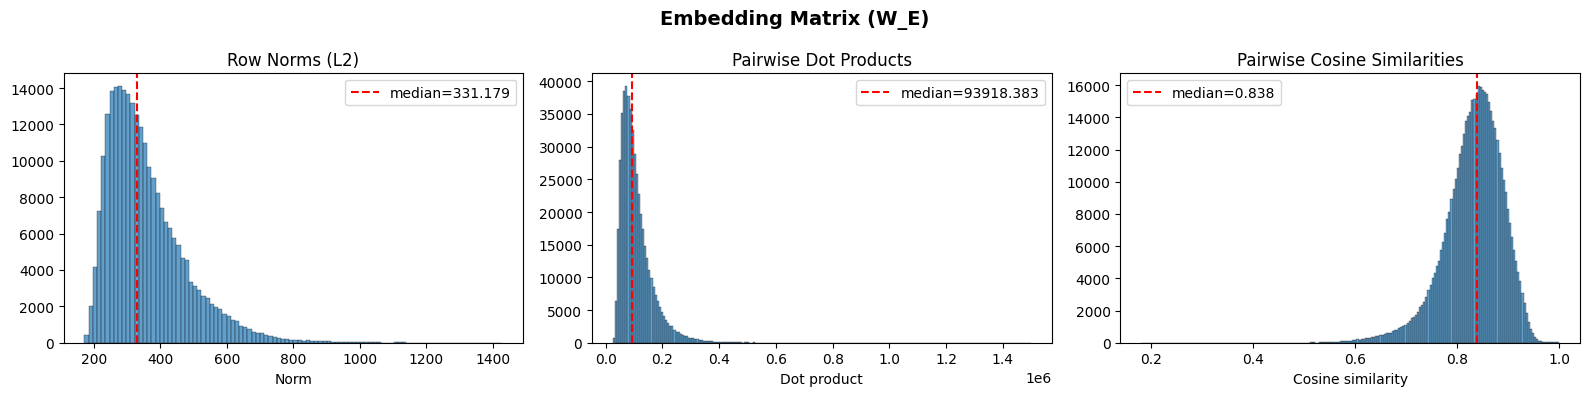

In [12]:
e_norms, e_dots, e_cosines = analyze_matrix(W_E, "Embedding Matrix (W_E)")
plot_distributions(e_norms, e_dots, e_cosines, "Embedding Matrix (W_E)")

## W_in of first MLP (block 0)

W_in has shape (d_model, d_mlp). The columns are the "neuron input directions" — each column is the direction in residual stream space that activates a particular MLP neuron. We analyze columns.


W_in columns (neuron input directions): 16384 vectors of dim 2048

Norms: mean=1.9507, std=0.5157, min=1.0227, max=5.7519, median=1.8098

Dot products (499964 sampled pairs):
  mean=-0.0002, std=0.2084, min=-8.8178, max=7.5608, median=-0.0001

Cosine similarities (499964 sampled pairs):
  mean=-0.0000, std=0.0368, min=-0.4450, max=0.4065, median=-0.0000


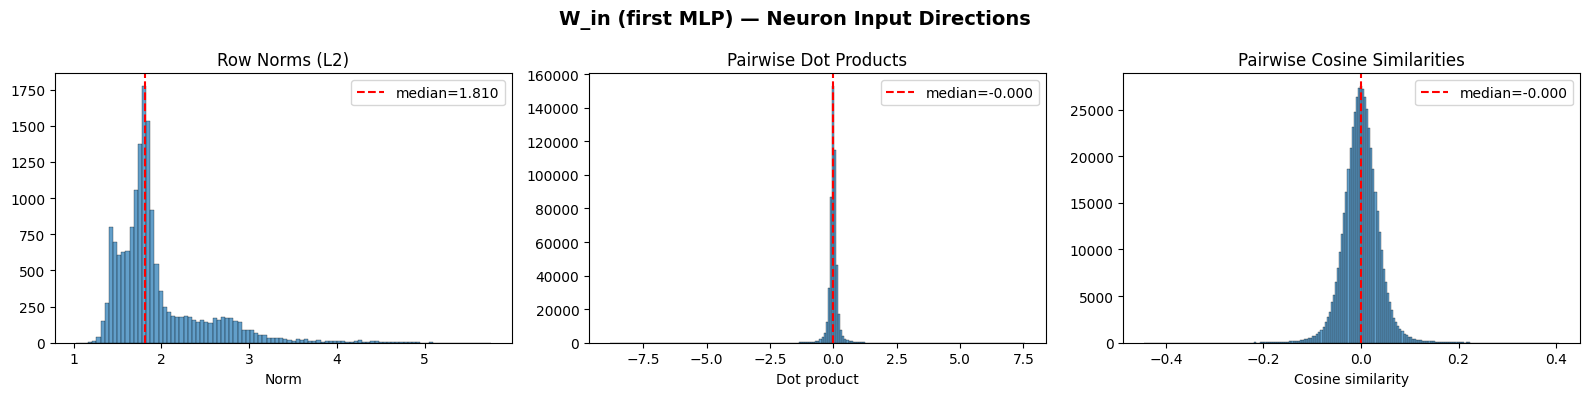

In [13]:
# Transpose so rows = neuron input directions
W_in_T = W_in.T  # (d_mlp, d_model)
w_norms, w_dots, w_cosines = analyze_matrix(W_in_T, "W_in columns (neuron input directions)")
plot_distributions(w_norms, w_dots, w_cosines, "W_in (first MLP) — Neuron Input Directions")

## Side-by-side comparison

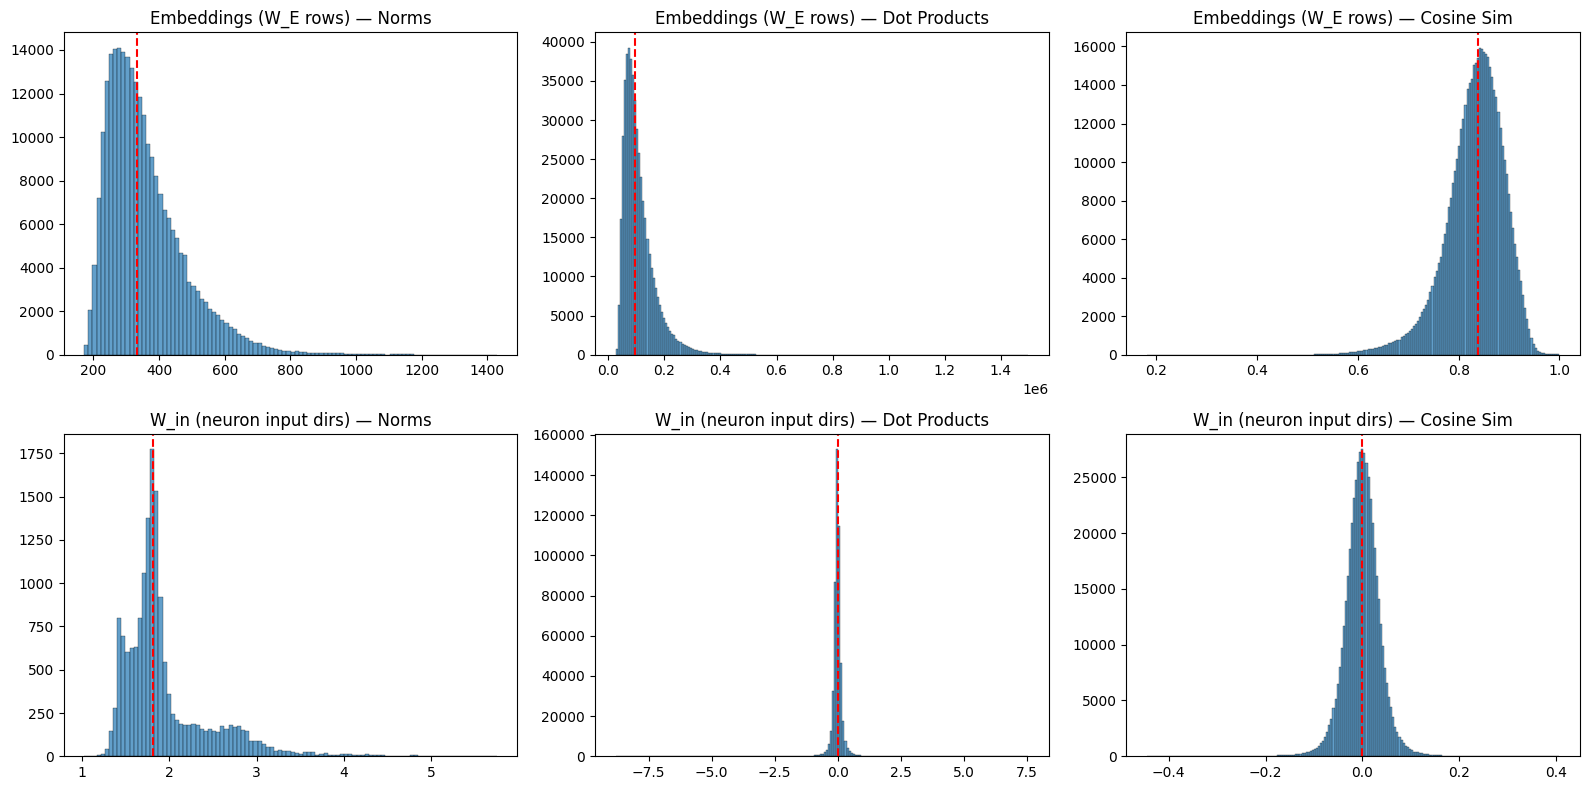

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for row, (norms, dots, cosines, label) in enumerate([
    (e_norms, e_dots, e_cosines, "Embeddings (W_E rows)"),
    (w_norms, w_dots, w_cosines, "W_in (neuron input dirs)"),
]):
    axes[row, 0].hist(norms, bins=100, alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[row, 0].set_title(f'{label} — Norms')
    axes[row, 0].axvline(np.median(norms), color='red', linestyle='--')
    
    axes[row, 1].hist(dots, bins=200, alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[row, 1].set_title(f'{label} — Dot Products')
    axes[row, 1].axvline(np.median(dots), color='red', linestyle='--')
    
    axes[row, 2].hist(cosines, bins=200, alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[row, 2].set_title(f'{label} — Cosine Sim')
    axes[row, 2].axvline(np.median(cosines), color='red', linestyle='--')

plt.tight_layout()
plt.show()

## Activation Space Analysis

For each embedding, compute the **gate** pre-activations: `gate_pre = embedding @ W_gate`.

Gemma uses GeGLU: `output = GELU(x @ W_gate) * (x @ W_in)`. The gate path determines
whether each neuron is active — GELU(x) ≈ 0 when x < 0, so we threshold at 0.

We convert to boolean activation patterns and analyze pairwise overlap:
- How many neurons fire per embedding on average?
- How many neurons do two embeddings have in common?
- How many pairs are completely disjoint (zero shared neurons)?
- Per-neuron frequency: which neurons are dead/sparse/always-on?

In [ ]:
# Compute gate activations for all embeddings
# GeGLU: output = GELU(x @ W_gate) * (x @ W_in)
# A neuron is "active" when its gate pre-activation > 0 (since GELU(x) ≈ 0 for x < 0)
#
# W_E: (vocab, d_model), W_gate: (d_model, d_mlp)
# gate_pre: (vocab, d_mlp)

chunk_size = 10000
n_vocab = W_E.shape[0]
d_mlp = W_gate.shape[1]

# Store boolean activation patterns
act_patterns = torch.zeros(n_vocab, d_mlp, dtype=torch.bool)

for start in range(0, n_vocab, chunk_size):
    end = min(start + chunk_size, n_vocab)
    gate_pre = W_E[start:end] @ W_gate  # (chunk, d_mlp)
    act_patterns[start:end] = gate_pre > 0
    if start % 50000 == 0:
        print(f"Processed {start}/{n_vocab}")

print(f"\nActivation patterns shape: {act_patterns.shape}")
print(f"Memory: {act_patterns.element_size() * act_patterns.numel() / 1e9:.2f} GB")

In [ ]:
# Per-embedding statistics: how many neurons fire?
neurons_per_embed = act_patterns.sum(dim=1).float()  # (vocab,)

print(f"Neurons firing per embedding:")
print(f"  mean:   {neurons_per_embed.mean():.1f} / {d_mlp} ({neurons_per_embed.mean()/d_mlp*100:.1f}%)")
print(f"  median: {neurons_per_embed.median():.1f}")
print(f"  std:    {neurons_per_embed.std():.1f}")
print(f"  min:    {neurons_per_embed.min():.0f}")
print(f"  max:    {neurons_per_embed.max():.0f}")

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(neurons_per_embed.numpy(), bins=100, alpha=0.7, edgecolor='black', linewidth=0.3)
ax.axvline(neurons_per_embed.mean(), color='red', linestyle='--', 
           label=f'mean={neurons_per_embed.mean():.0f}')
ax.axvline(neurons_per_embed.median(), color='orange', linestyle='--',
           label=f'median={neurons_per_embed.median():.0f}')
ax.set_xlabel('Number of active neurons')
ax.set_ylabel('Count')
ax.set_title('Neurons firing per embedding (W_E @ W_in > 0)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Pairwise activation overlap analysis
# Full pairwise on 256k embeddings is infeasible (256k^2 = 65B pairs)
# Sample random pairs and compute Jaccard / intersection stats

n_pairs = 1_000_000
idx_a = torch.randint(0, n_vocab, (n_pairs,))
idx_b = torch.randint(0, n_vocab, (n_pairs,))
# Remove self-pairs
mask = idx_a != idx_b
idx_a, idx_b = idx_a[mask], idx_b[mask]
n_pairs = len(idx_a)
print(f"Analyzing {n_pairs:,} random pairs...")

# Process in chunks to avoid memory issues
pair_chunk = 50000
intersections = []
unions = []
only_a_counts = []
only_b_counts = []

for start in range(0, n_pairs, pair_chunk):
    end = min(start + pair_chunk, n_pairs)
    a = act_patterns[idx_a[start:end]]  # (chunk, d_mlp)
    b = act_patterns[idx_b[start:end]]  # (chunk, d_mlp)
    
    inter = (a & b).sum(dim=1).float()
    union = (a | b).sum(dim=1).float()
    only_a = (a & ~b).sum(dim=1).float()
    only_b = (~a & b).sum(dim=1).float()
    
    intersections.append(inter)
    unions.append(union)
    only_a_counts.append(only_a)
    only_b_counts.append(only_b)

intersections = torch.cat(intersections)
unions = torch.cat(unions)
only_a_counts = torch.cat(only_a_counts)
only_b_counts = torch.cat(only_b_counts)
jaccards = intersections / unions.clamp(min=1)

print(f"\nPairwise activation overlap ({n_pairs:,} pairs):")
print(f"  Intersection (shared neurons):")
print(f"    mean:   {intersections.mean():.1f}")
print(f"    median: {intersections.median():.1f}")
print(f"    std:    {intersections.std():.1f}")
print(f"    min:    {intersections.min():.0f}")
print(f"    max:    {intersections.max():.0f}")
print(f"\n  Union:")
print(f"    mean:   {unions.mean():.1f}")
print(f"\n  Jaccard similarity (intersection/union):")
print(f"    mean:   {jaccards.mean():.4f}")
print(f"    median: {jaccards.median():.4f}")
print(f"    std:    {jaccards.std():.4f}")
print(f"\n  Disjoint pairs (zero shared neurons): "
      f"{(intersections == 0).sum().item():,} / {n_pairs:,} "
      f"({(intersections == 0).float().mean()*100:.2f}%)")
print(f"  High-overlap pairs (Jaccard > 0.5): "
      f"{(jaccards > 0.5).sum().item():,} / {n_pairs:,} "
      f"({(jaccards > 0.5).float().mean()*100:.2f}%)")
print(f"  Near-identical pairs (Jaccard > 0.9): "
      f"{(jaccards > 0.9).sum().item():,} / {n_pairs:,} "
      f"({(jaccards > 0.9).float().mean()*100:.2f}%)")

In [ ]:
# Visualize overlap distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].hist(intersections.numpy(), bins=100, alpha=0.7, edgecolor='black', linewidth=0.3)
axes[0].set_xlabel('Shared active neurons')
axes[0].set_ylabel('Count')
axes[0].set_title('Pairwise intersection size')
axes[0].axvline(intersections.mean(), color='red', linestyle='--',
                label=f'mean={intersections.mean():.0f}')
axes[0].legend()

axes[1].hist(jaccards.numpy(), bins=100, alpha=0.7, edgecolor='black', linewidth=0.3)
axes[1].set_xlabel('Jaccard similarity')
axes[1].set_ylabel('Count')
axes[1].set_title('Pairwise Jaccard (intersection/union)')
axes[1].axvline(jaccards.mean(), color='red', linestyle='--',
                label=f'mean={jaccards.mean():.4f}')
axes[1].legend()

# Scatter: neurons_a vs intersection with neurons_b
n_a = neurons_per_embed[idx_a].numpy()
n_b = neurons_per_embed[idx_b].numpy()
inter_np = intersections.numpy()

# Subsample for scatter (1M points is too dense)
scatter_idx = np.random.choice(len(n_a), size=min(50000, len(n_a)), replace=False)
axes[2].scatter(n_a[scatter_idx], inter_np[scatter_idx], s=0.5, alpha=0.1)
axes[2].set_xlabel('Active neurons in embedding A')
axes[2].set_ylabel('Shared neurons with embedding B')
axes[2].set_title('Sparsity vs overlap')

plt.tight_layout()
plt.show()

In [ ]:
# Per-neuron statistics: how often does each neuron fire?
neuron_freq = act_patterns.float().mean(dim=0)  # (d_mlp,) — fraction of embeddings activating each neuron

print(f"Per-neuron activation frequency:")
print(f"  mean:   {neuron_freq.mean():.4f} ({neuron_freq.mean()*100:.2f}% of embeddings)")
print(f"  median: {neuron_freq.median():.4f}")
print(f"  std:    {neuron_freq.std():.4f}")
print(f"  Dead neurons (never fire):  {(neuron_freq == 0).sum().item()} / {d_mlp}")
print(f"  Always-on neurons (>99%):   {(neuron_freq > 0.99).sum().item()} / {d_mlp}")
print(f"  Sparse neurons (<1%):       {(neuron_freq < 0.01).sum().item()} / {d_mlp}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(neuron_freq.numpy(), bins=100, alpha=0.7, edgecolor='black', linewidth=0.3)
axes[0].set_xlabel('Activation frequency')
axes[0].set_ylabel('Count')
axes[0].set_title('Per-neuron activation frequency across all embeddings')
axes[0].axvline(0.5, color='gray', linestyle=':', alpha=0.5, label='50%')
axes[0].legend()

# Sorted activation frequency (like a rank-frequency plot)
sorted_freq, _ = neuron_freq.sort(descending=True)
axes[1].plot(sorted_freq.numpy(), linewidth=0.8)
axes[1].set_xlabel('Neuron rank')
axes[1].set_ylabel('Activation frequency')
axes[1].set_title('Neuron activation frequency (sorted)')
axes[1].axhline(0.5, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()